In [1]:
] activate .

  Activating project at `~/workspace`


[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


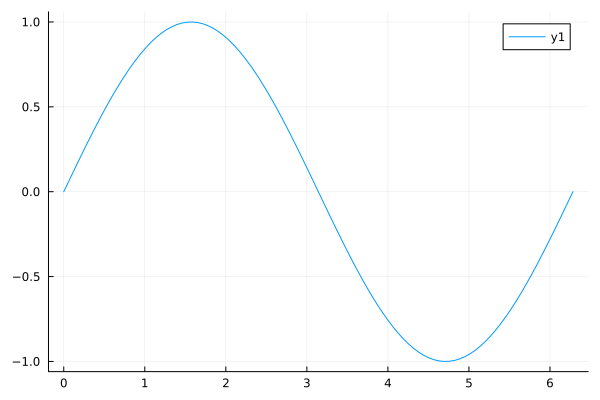

In [2]:
using Plots

x = LinRange(0,2 * pi,100)
plot(x,sin.(x))

trying some math

$$ \beta \int x dx $$ 